# Data cleaning
---
EN industrie, les données récoltées sont très souvent incomplètes et/ou bruitées. Il est donc nécessaire des les netttoyer afin de générer un jeu de données nettoyé brut, qui servira par la suite à l'entraînement de modèles et l'élaboration de dashboards.

Les étapes du traitement de données :
1. **Import des librairies**
2. **Import du dataset**
    1. en CSV
    2. en xlsx/xlsm
    3. en parquet
    4. Quelques notions sur le *big data*
3. **Analyse descriptive du fichier brut**
    1. Visualisation des tendances et de la stationnarité (*séries temporelles*)
    2. Statistique descriptive
4. **Gestion des données manquantes**
    1. Détection des valeurs manquantes
    2. imputation ou supression (selon cas)
5. **Gestion des doublons** (si pertinent)
6. **Gestion des outliers**
    1. Détection des outliers univariés
    2. Détection des outliers multivariés
    3. Supression des outlers univariés
    4. Supression des outliers multivariés
7. **Feature engineering**
    1. Resampling (*séries temporelles*)
    2. Ajout de lags (*séries temporelles*)
8. **Encodage** (*Variables multiclasses*)
    1. One-hot encoding (si peu de catégories)
    2. Ordinal encoding (si les catégories sont ordonnées)
    3. Embeddings (si modèle deep learning)
    4. Frequency or Target encoding (si très nombreuses catégories)
9. **Apprentissage actif** (si pertinent)
10. **Shrinkage**
11. **Standardisation**

# I. Import des librairies
---
## 1.1 Import des librairies nécéssaires pour les scripts et des datasets d'exemples.

In [6]:
# Graphs
import pandas as pd
import matplotlib.pyplot as plt
from skimpy import skim
import plotly.express as px
import seaborn as sns

# Datasets
from sklearn.datasets import load_iris

# Autre
from skimpy import skim 
import torch
from tqdm import tqdm as tqdm_base # Barre de progression dans les boucles

## 1.2 Import des fonctions personnalisées

In [7]:
import sys
sys.path.append('~/Pipeline_Data_Science/MachineLearning/src/python')

import _split_var_quali_quanti as _split_var_quali_quanti
sys.path.append('~/Pipeline_Data_Science/MachineLearning/')

ModuleNotFoundError: No module named '_split_var_quali_quanti'

## 1.3 Panneau général de configuration
C'est un framework qui permet de tracer des graphes avec une esthétique et des barres de progressions customisées, rajoutent de la clareté pour non seulement l'analyse, le data scientist, mais aussi le manager et le client final. Cette partie peut être modifiée à votre guise et ne dépend que de ce que vous voulez obtenir dans votre analyse descriptive.

La librairie **tqdm** permet de rajouter une barre de progression sur les *for loop*, ce qui permet de savoir ou en est la machinee dans le traitement des données ou l'entraînement des modèles. Cela évite de perdre du temps à attendre que la machine finisse d'exécuter le script sans avoir une estimation du temps d'exécution. Avec Pytorch, on peut savoir en un coup d'oeil si on a un ou plusieurs GPU disponibles pour la pipeline. En règle générale, l'utilisation d'un ou de plusieurs GPU est nettement plus rapide sur certaines tâches spécifique qu'en utilisation CPU. En revanche, certaines librairies ne sont compatibles que CPU only.


In [8]:
# Configuration de l'utilisation GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Utilisation GPU" if device.type == "cuda" else "Utilisation du CPU")

# Configuration esthétique
import seaborn as sns
sns.set_style("darkgrid")

from tqdm import tqdm as tqdm_base # Barre de progression dans les boucles
def tqdm(*args, **kwargs): # Barre de progression sur les boucles
    kwargs.setdefault("bar_format", "{l_bar}{bar}| {n_fmt}/{total_fmt} • {elapsed} • {rate_fmt}")
    kwargs.setdefault("ascii", "░▒█")  # style du remplissage
    kwargs.setdefault("ncols", 90)    # largeur de la barre
    kwargs.setdefault("colour", "green")  # couleur (nécessite tqdm>=4.62.0)
    kwargs.setdefault("dynamic_ncols", False)
    return tqdm_base(*args, **kwargs)

import pandas as pd
tqdm_base.pandas(
    desc="Nettoyage", 
                 bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} • {elapsed} • {rate_fmt}",
                 ascii="░▒█",
                 ncols=90,
                 colour="green"
)

Utilisation GPU


# II Import du dataset
---
## 2.1 Import d'un fichier CSV / excel / parquet
La grande majorité des datasets sont issus d'un fichier CSV (.csv) ou Excel (.xlsx ou .xlsm). On prend le fichier "ozone_complet.csv" pour l'exemple. Attention ici à spécifier les séparateurs en mode anglosaxon (,) ou français (;) qui peuvent poser des problèmes d'import. De même pour les virgules des nombres flottants anglosaxons (.) et français (,).

1. On corrige le problème de séparateur grâce à la commande `sep` pour transformer l'interprétation du fichier.csv. On spécifie ";" pour transformer le mode anglosaxon en mode français.
2. On corrige le problème de décimales grâce à la commande `decimal`. Pour passer des décimales "anglosaxonnes" au format "français", on spécifie la valeur ",". 

In [9]:
df = pd.read_csv(
    'src/data/raw/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

Un df.head() permet d'avoir un rapide aperçu du dataset et de vérifier si il a bien été importé

In [10]:
df.head()

maxO3    T6    T9   T12   T15   T18  Ne6  Ne9  Ne12  Ne15  ...  \
date                                                                 ...   
19950401   47.6  10.1  11.6  13.3  13.6  12.2  8.0  8.0   8.0   8.0  ...   
19950402   56.2   9.5   9.4  13.8  17.4  16.3  8.0  8.0   7.0   0.0  ...   
19950403   61.8   3.6   8.0  16.8  21.5  20.2  4.0  5.0   2.0   2.0  ...   
19950404   50.8   9.5  10.5  11.4  12.2  11.4  8.0  7.0   7.0   7.0  ...   
19950405   59.8   9.8  10.8  13.8  14.3  13.3  8.0  7.0   8.0   8.0  ...   

          Vdir9  Vvit9  Vdir12  Vvit12  Vdir15  Vvit15  Vdir18  Vvit18  \
date                                                                     
19950401  290.0    4.0   300.0     4.0   340.0     4.0    20.0     4.0   
19950402  160.0    2.0   180.0     3.0   110.0     1.0   350.0     2.0   
19950403   20.0    2.0   340.0     1.0   170.0     2.0   170.0     3.0   
19950404   10.0    4.0   350.0     3.0   350.0     3.0   350.0     4.0   
19950405  340.0    2.0   280.0     1.0   320.0     3.0   350.0     4.0   

              Vx  maxO3v  
date                      
19950401 -3.4641    62.2  
19950402  0.0000    47.6  
19950403 -0.3420    56.2  
19950404 -0.5209    61.8  
19950405 -0.9848    50.8  

[5 rows x 23 columns]

Nota : on peut faire la même chose avec des fichiers .xlsx, .xlsm ou .parquet grâce aux méthodes **df.read_excel** et **df.read_parquet** respectivement

## 2.2 import d'un dataset built-in d'une librairie
On peut prendre un dataset déjà présent dans une librairie, comme `iris` de la librairie `sklearn`. Ces datasets dit "sandbox" sont à but pédagogiques ou pour le prototypage, on peut en retrouver dans certaines librairies comme `sklearn` ou `seaborn`. D'autres datasets sandbox plus proches de la réalité peuvent se trouver sur le site Kaggle : 

https://www.kaggle.com/search

ce site répertorie un ensemble assez conséquent de jeux de données qui proviennent d'horizons variées. De plus, les utilisateurs peuvent proposer une analyse de ce même jeu de données, ce qui permet d'avoir un premier aperçu si on a du mal à démarrer ou tout simplement si opn veuts'affranchier d'une étape de l'analyse pour une quelconque raison.

In [13]:
iris = load_iris() # Charge le dataset
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

## 2.3 Conversion des datasets pour optimisation
Convertir des gros fichiers excels peut s'avérer être une bonne option pour réduire le temps de calcul et l'utilisation de la RAM de la machine. Pour des fichiers .xlsx/.xlsm de petite taille, on peut s'affranchir de cette étape. En revanche, pour des datasets plus gros, mieux vaut convertir en .csv (fichiers vectorisés) ou en .parquet. Les fichiers parquets sont très rapides et utilisent peu de RAM. Voici un tableau récupitulatif des extensions rencontrées en *data science*.

### 2.3.1 Structures de données usuelles rencontrées en industrie

| Format      | Extension(s)   | Type              | Avantages clés                                               | Inconvénients / Limitations                     
|-------------|----------------|-------------------|----------------------------------------------------------------|------------------------------------------------------|
| Excel       | `.xls`, `.xlsx`,`.xlsm`| Binaire / XML     | Très répandu, facile à lire | Lourd, lent |
| CSV         | `.csv`         | Texte (délimité)  | Simple, facile à lire                            | Pas de compression             
| TSV         | `.tsv`         | Texte (délimité)  | Comme CSV, mais avec tabulation                              | Pas de compression                        
| JSON        | `.json`        | Texte (structuré) | Lisible, mais moins que le CSV ou Excel, utilse pour les applications Web.                   | Pas efficace pour les tables larges
| XML         | `.xml`         | Texte (structuré) | Standard                                                     | Fichiers très lourds          
| Pickle      | `.pkl`         | Binaire (Python)  | Rapide avec Python                             | Compatible uniquement avec Python       
| HDF5        | `.h5`, `.hdf5` | Binaire (hiérarchique) | Efficace pour de gros volumes, structuré                       | Plus complexe, dépendances externes              
| Feather     | `.feather`     | Binaire (Apache Arrow) | Le plus rapide, support natif avec pandas                     | Moins compressé que Parquet                      
| Parquet | `.parquet`     | Binaire (colonnaire) | Très efficace pour les gros datasets, compressé, sécurisé | Moins lisible, nécessite des outils     

à titre d'exemple, un fichier excel commence à montrer ses limites à partir de 1M de lignes (~ 500Mo), après quoi le chargement dufichier et de toute l'analyse qui s'en suit sera plus longue et succeptible de crasher. De plus, les extensions .hdf5 et .parquet sont optipmisées pour les fichier très volumineux car ils utilisent moins de RAM et leurs taille est plus ppetite pour la même quantité d'information brute. Il est donc préférable, à partir d'un certain volume de données de convertir le fichier excel en fichier .pparquet par exmeple. Voici un tableau qui résume l'extension conseillée en fonction de la taille du fichier 

### 2.3.2 Structure de données recomandée par classées par taille de dataset 

| Catégorie | Nombre de lignes | Taille du fichier | Extensions recommandées | Commentaire |
| :--- | :--- | :--- | :--- | :--- |
| **Petits Fichiers** | Moins de 1 million | Jusqu'à ~500 Mo | `.xlsx`, `.csv` | **`.xlsx` (Excel)** : Idéal pour la manipulation manuelle, le partage avec des non-informaticiens et les analyses simples. **`.csv`** : optimisé, vectorisé et lisible. Très répandu et facile d'utilisation mais peut montrer ces limites pour des fichier très volumineux |
| **Fichiers Moyens** | De 1 million à 10 millions | De 500 Mo à 5 Go | `.json` | **`.csv`** : Encore utilisable, mais les temps de chargement commencent à être notables. **`.json`** : optimisé pour les données avec une structure hiérarchique et répandu pour les APIs web. Moins performant pour les très grands volumes de données tabulaires. |
| **Gros Fichiers** | Plus de 10 millions | De 5 Go à 100 Go | `.parquet`, `.feather` | **`.parquet`** : Stockage en colonnes, ce qui permet une compression très efficace et des lectures de données très rapides. Idéal pour les analyses de machine learning. **`.feather`** : Extrêmement rapide pour la lecture et l'écriture, conçu pour un usage temporaire ou intermédiaire entre des processus (par exemple, entre Python et R). Moins compressé que Parquet et moins répandu. |
| **Très Gros Fichiers** | Des centaines de millions ou plus | Plus de 100 Go | `.parquet`, `.hdf5` | **`.parquet`** : Toujours très répandu. il arrive de voir des fichiers en **`.hdf5` (Hierarchical Data Format)** : Conçu pour des données scientifiques et numériques très volumineuses et complexes. Permet de stocker de multiples jeux de données dans un seul fichier de manière hiérarchique et d'accéder à des sous-ensembles de données sans charger tout le fichier en mémoire. |

Un exemple de compression de fichier CSV en Parquet :

In [23]:
# Conversion en une seule fois pour optimisation

df = pd.read_csv( # import du fichier CSV
    'src/data/raw/ozone_complet.csv',
    header    = 0,
    index_col = 0,
    sep       = ';',
    decimal   = ','
)

df.to_parquet("src/data/raw/ozone_complet.parquet", index=False) # Conversion puis stockage du fihcier sous la nouvelle extension Parquet

**Attention : cette étape n'est à faire qu'une fois, il est conseillé de commenter cette partie après la première exécution pour éviter de réécraser les mêmes données à chaque fois, ce qui ferai perdre du temps inutilement lors de l'étude**

## 2.4 Quelques notions sur le big data

Un *datasicentist* se retrouvera régulièrement dans la situation ou la taille des fichiers et leurs valeur sont telles que leur stockage en local sur sa propre machine ne suffit plus. Dans ces cas là, soit les données sont récoltées sur le web (grâce à des techniques de *web-scrapping*), soit elles sont générées et stockées au sein de l'entreprise sur des *data centers* / *data lakes*. Une telle infrastructure est gérée par des outils comme Spark. 

https://spark.apache.org/

# III Analyse descriptive du fichier brut
---

## 3.1 Description statistique de base 

On réalise d'abord un première analyse du fichier brut pour savoir de quoi le dataset parle. Dans toute la suite de cette partie, on prendra l'exemple de la consommation d'énergie horaire d'une partie des états des Etats Unis de 2004 à 20218. Ce jue de données est disponbile sur le lien suivant : 

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download

Une anaylse a été réalisée sur ce jeu de données sur Kaggle. Lien : 

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [15]:
df = pd.read_csv( # import du fichier CSV
    'src/data/raw/AEP_hourly.csv',
)

df.head()

Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

Ici, on utilise la librairie **skimpy**, qui propose un résumé relativement clair du dataset. Cette méthode remplace **df.describe** pour des soucis de lisibilité.

In [25]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 121273 │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column    ┃ NA   ┃ NA %   ┃ mean     ┃ sd     ┃ p0     ┃ p25      ┃ p50     ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ AEP_MW    │    0 │      0 │    15500 │   2591 │   9581 │    13630 │   15310 │   17200 │   25700 │  ▂██▄▁   │  │
│ └───────────┴──────┴────────┴──────────┴────────┴────────┴──────────┴─────────┴─────────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃          ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per  ┃ words per ┃ total      ┃  │
│ ┃ column   ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row        ┃ row       ┃ words      ┃  │
│ ┡━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ Datetime │  0 │    0 │ 2004-12-3 │ 2004-12-3 │ 2004-10-0 │ 2018-08-0 │         19 │         2 │     242546 │  │
│ │          │    │      │ 1         │ 1         │ 1         │ 3         │            │           │            │  │
│ │          │    │      │ 01:00:00  │ 01:00:00  │ 01:00:00  │ 00:00:00  │            │           │            │  │
│ └──────────┴────┴──────┴───────────┴───────────┴───────────┴───────────┴────────────┴───────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

**Skimpy** propose une interface épurée et donne plus d'informations, notament pour les variables de type classe / multiclasse, mais aussi les chaînes de caractères ou tout autre varible non-continue. Voici un détail de ce que **Sympy** peut faire : 

| Statistique | Description | Types de Variables Concernées |
| :--- | :--- | :--- |
| **`n_missing`** | Le nombre total de valeurs manquantes (`NaN`) dans la colonne. | Toutes |
| **`complete_rate`** | Le pourcentage de valeurs non manquantes. C'est l'inverse du taux de valeurs manquantes. | Toutes |
| **`dtype`** | Le type de données de la colonne (ex: `float64`, `int64`, `object`, `bool`). | Toutes |
| **`mean`** | La **moyenne** arithmétique des valeurs. | Numériques (`int`, `float`) |
| **`sd`** | L'**écart-type** (Standard Deviation), qui mesure la dispersion des données autour de la moyenne. | Numériques (`int`, `float`) |
| **`p0`** | Le **minimum** (0ème percentile). La plus petite valeur de la colonne. | Numériques, Datetime |
| **`p25`** | Le **premier quartile** (25ème percentile). 25% des données sont inférieures à cette valeur. | Numériques, Datetime |
| **`p50`** | La **médiane** (50ème percentile). La valeur du milieu ; 50% des données sont inférieures. | Numériques, Datetime |
| **`p75`** | Le **troisième quartile** (75ème percentile). 75% des données sont inférieures à cette valeur. | Numériques, Datetime |
| **`p100`** | Le **maximum** (100ème percentile). La plus grande valeur de la colonne. | Numériques, Datetime |
| **`hist`** | Un petit **histogramme** textuel (sparkline) qui visualise la distribution des données. | Numériques (`int`, `float`) |
| **`n_unique`** | Le nombre de **valeurs uniques** (distinctes) dans la colonne. | Catégorielles, Booléennes, Datetime |
| **`top_counts`** | Les valeurs les plus fréquentes et leur nombre d'occurrences. Très utile pour les catégories. | Catégorielles (`object`, `string`) |
| **`true` / `false`** | Le nombre de valeurs `True` ou `False`. | Booléennes (`bool`) |


## 3.2 Histogramme de $y$

ici, on cherche à afficher l'histogramme de la varibale cible, que l'on définiera dans le code. On aura donc la variable **target** = AEP_MW qui correspondra à l'énergie consommée (en MWh) d'un groupe d'états aux Etats-Unis (dont on peut avoir le détail dans le lien associé aui site Kaggle).
C'est donc la variable $y$ que l'on cherche à modéliser. D'une manière générale, on cherche à modéliser une variabble cible $y$ de la manière suivante : 

$$
y =  \sum_{i=1}^{N}\beta_{i}\phi_{i}(X_{i})
$$

Avec : 

1. $\beta_{i}$ : coefficients de la régression
2. $\phi_{i}$ : fonctions continues sur l'espace des observations
3. $X_{i}$ : covariables qui expliquent la varibale dépendant (ou cible)

**L'objectif est de savoir si il y a une proportion non négligeable de'échantillons ou la variable cible s'annule, cela sera utile pour l'entraînement des modèles car les modèles comme XGBoost voient leurs performance se dégrader lorsque la valeur cible s'annule en certains points.**

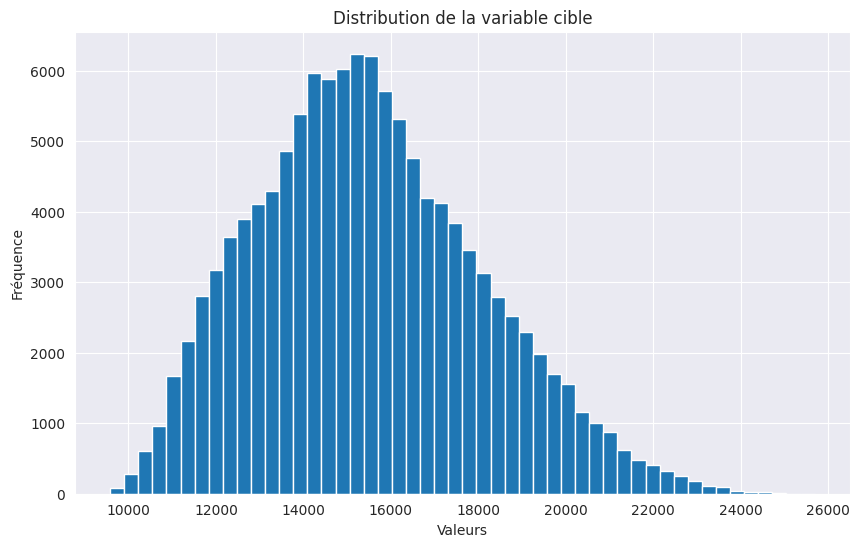

In [30]:
target = "AEP_MW"

plt.figure(figsize=(10, 6))
plt.hist(df[target], bins=50)
plt.title("Distribution de la variable cible")
plt.xlabel("Valeurs")
plt.ylabel("Fréquence")
plt.show()

## 3.3 Plot de $y$

On met la date en tant qu'index au lieu d'avoir comme index par défaut le numéro de la ligne, puis on la converti en format date reconnue par pandas.
Cela permet d'indexer l'axe temproel en format date au lieu d'un simple float qui fait perdre le sens du graphique

In [35]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.head()

AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0

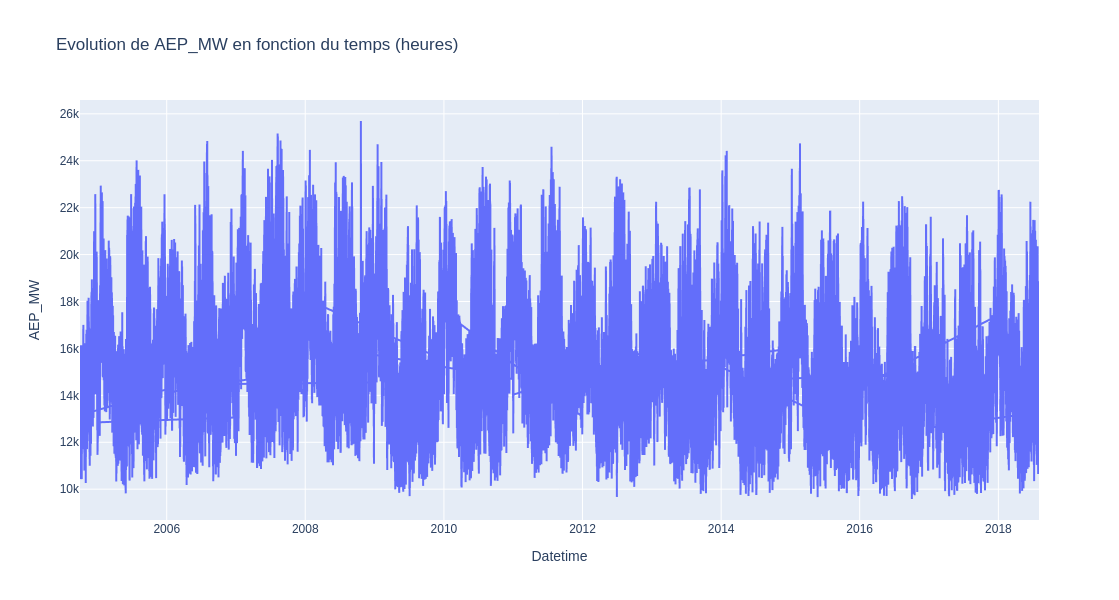

In [36]:
fig = px.line(
    df,
    x=df.index,
    y=target,
    title=f'Evolution de {target} en fonction du temps (heures)')

fig.update_layout( # Taille augmentée pour la lisibilité
    width=1100,
    height=600
)

fig.show() # Affichage

On peut voir que la consommation d'énergie suit une tendance saisonnière, c'est déjà une information très utile pour le test de saisonnarité et de stationnarité

### 3.3.1 Sous-échantillonage (sampling)
Le sampling permet de ne considérer qu'une seule partie de l'échantillon afin de faire l'analyse sur unn jeu de données réduit pour gagner du temps d'exécution. Il faudra prendre l'intégralité du dataset pour l'entraînement d'un modèle en production et ne pas oublier de considérer une proportion assez importante pour avoir de bonnes métriques sur le sampling. En somme, le sampling peut être une bonne alternative pour gagner du temps pourvu que l'on prenne un échantillon représentatif du jeu de données. 

# IV Feature engineering
---
## 4.1 Intérêt du feature engineering

L'objectif principal du feature engineering est de rajouter des informations afin de faire apparaître certains aspets du jeu de données. Les features statistiques comme la moyenne glissante permettent aux statisticiens et analystes de mettre en lumière une tendance globale sur un processus stochastique *à priori* peu clair. L'écart type sur une fenêtre glissante permet de détecter les outliers (valeurs abérantes ou anomalies statistiques) et de vérifier la stationnarité du signal. Ce dernier test statistique permet d'ajiuster au mieux les paramètres de chacun des modèles testés. 

Les features comme les lags permettent aux modèles de boosting et de la famille des modèles autorégressifs comme ARIMA ou SARIMA d'interpréter fidèlement les tendances et les périodicités.

L'encodage des valeurs temporelles permet de rajouter des informations cruciales aux modèles pour affiner leurs modélisations. Ce genre de features permettent à la quasi-totalité des modèles d'améliorer leurs performances grâce au simple rajout de ces variables.

Le feature engineering offre tout un panel de nouvelles features qui peuvent enrichir le jeu de données. Attention cependant à ne pas trop en rajouter pour ne pas rajouter du bruit, de la confusion dans le dataset ou encore éviter le data leakage.

*le data leakage est un phénomène qui a pour conséquences d'avoir des perforpmances execptionnelles en test mais qui rend le modèle inutilisable en production, notament à cause de l'overfitting.*

## 4.2 Feature engineering sur la date

### Feature engineering sur la date

I Encodage linéaire

1. **Date** : Encodage de la date

        2024-06-03 00:10:00

2. **Minute** : Encodage des minutes. Exemple :

        2024-06-03 00:10:00 donne 10
 
3. **Heure** : Encodage de l'heure. Exemple :

        2024-08-24 01:30:00 donne 1
   
4. **HeureDecimal** : Encodage de l'heure et des minutes. Exemple :

        2024-08-24 01:30:00  donne 1,5

5. **JourSemaineStr** : Encodage du jour de la semaine en Français. Exemple :

       2024-08-24 01:30:00 donne "Samedi"

5. **Mois** : Encodage du mois. Exemple :

       2024-08-24 01:30:00 donne "8"

5. **MoisStr** : Encodage du mois de l'anné en Français. Exemple :

       2024-08-24 01:30:00 donne "Août"

9. **JourSemaineNum** : Encodage du jour de la semaine en fonction de son numéro dans la semaine. Exemple :

       2024-08-24 01:30:00 donne 6

10. **JourMois** : Encodage du jour de la semaine en fonction de son numéro dans le mois. Exemple :

        2024-08-24 01:30:00 donne 8

11. **Annee** : Encodage de l'année. Exemple :

        2024-08-24 01:30:00 donne 2024

12. **AnneeNormalized** : Encodage de l'année normalisée dans $[0;1]$

II Encodage cyclique

Les encodages cycliques permettent de donner du sens aux distances temporelles pour les algorithmes de machine learning. Par exemple, un encodage linéaire prendra le premier jour du mois comme étant le numéro 1, le dernier comme étant le numéro 31. Un algorithme de machine learning estimera que ces deux jours sont très éloignés, alors qu'en réalité ils sont très proches (à un mois près). On utilise alors des fonctions cyclique comme les fonctions trigonométriques usuelles pour rapprocher des distances temporelles éloignées linéairement. Pour que les modèles puissent capturer cet aspet de l'étude, on ne garde que l'encodage cyclique pour les features

<div align="center">
  <img src="src/img/CyclicalEncodingDay.png" alt="a" width="500" height="300">
</div>

1. **sin** :

$$
Jour\_sin = sin(\frac{2\pi N_j}{T})
$$

ou $T$ est la période en semaines (7), mois (31) ou années (365) et $N_j$ le numéro de jour par rapport à la période.

1. **cos** :

$$
Jour\_sin = cos(\frac{2\pi N_j}{T})
$$

ou $T$ est la période en semaines (7), mois (31) ou années (365) et $N_j$ le numéro de jour par rapport à la période.

In [ ]:
try:
    with timer('Feature engineering - date'):
        
        ########## Init ##########
        
        original_columns = set(df.columns)
        df["Date"] = df.index.date
        df.index = pd.to_datetime(df.index)
        
        ########## Encodage linéaire ##########
        
        # Encodage des minutes
        #df["minute"] = df.index.minute
        
        # Encodage des heures
        #df["heure"] = df.index.hour
        #df["heure_decimal"] = df["heure"] + df["minute"] / 60
        
        # Encodage du jour
        #df['jour_semaine_str'] = df.index.weekday.map(lambda x: jours_fr[x])
        #df['jour_semaine_num'] = df.index.weekday
        #df['jour_mois'] = df.index.day
        
        # Encodage de la semaine
        
        # Encodage du mois
        #df['mois'] = df.index.month
        #df["mois_str"] = df.index.month.map(lambda x: mois_fr[x - 1])
        
        
        # Encodage de l'année
        df_annee = df.index.year
        scaler = MinMaxScaler()
        df['anne_normalized'] = scaler.fit_transform(df_annee) # Année normalisée entre 0 et 1
        
        
        ########## Encodage cyclique ##########
        
        # Période annuelle
        
        # Période mensuelle
        df["jour_sin"] = np.sin(2 * np.pi * df["jour_mois"] / 31)
        df["jour_cos"] = np.cos(2 * np.pi * df["jour_mois"] / 31)
        
        # Période hebdomadaire
        
        # Période journalière
        df["heure_sin"] = np.sin(2 * np.pi * df["heure"] / 24)
        df["heure_cos"] = np.cos(2 * np.pi * df["heure"] / 24)
        
        # Période horraire
        df["minute_sin"] = np.sin(2 * np.pi * df["minute"] / 60)
        df["minute_cos"] = np.cos(2 * np.pi * df["minute"] / 60)

        df = df.astype(dtypes_FE_dates) 

        current_columns = set(df.columns)
        new_features = list(current_columns - original_columns)

except Exception as e:
    print(f"Feature engineering on dates failed to be implemented. \n Error : {e}")

In [ ]:
__dict__ = {
    "Nb NaN values" :       [len(df[df[key] == 0].index.tolist()) for key in dtypes_FE_dates.keys()],
    "Proportion" :          ["{:.2f}".format(
                                         len(df[df[key] == 0].index.tolist()) / len(df[key])
                                    ) for key in dtypes_FE_dates.keys()],
    "Len. of feat. vect." : [len(df[key]) for key in dtypes_FE_dates.keys()]
}

__nul_values__ = pd.DataFrame(
    __dict__,
    index=[key for key in dtypes_FE_dates.keys()]
)

__nul_values__

### Gestion des jours fériés.

In [ ]:
try:
    with timer('Feature engineering - holidays'):

        # Init
        original_columns = set(df.columns)
        jours_feries = holidays.FR()


        df = df.reset_index("date_de_debut") # index à remettre par la suite 
        
        # Jours fériés et jour d'avant / après pour la robustesse du modèle
        df['est_ferie'] = df['date_de_debut'].apply(lambda date: date in jours_feries)
        df['veille_ferie'] = df['est_ferie'].shift(-1, fill_value=False)
        df['lendemain_ferie'] = df['est_ferie'].shift(1, fill_value=False)

        df = df.astype(dtypes_holidays) 
        
        current_columns = set(df.columns)
        new_features = list(current_columns - original_columns)

except Exception as e:
    print(f"Feature engineering on holidays failed to be implemented. \n Error : {e}")

### Features statistiques

1. **moving_avg** : Moyenne mobile ($MA$) sur une fenêtre glissante exprimée en minutes

2. **moving_std** : Ecart-type mobile ($Mstd$) sur une fenêtre glissante exprimée en minutes

3. **sensitivity** : Coefficient de sensibilité ($s$) autour de la moyenne mobile

4. **EWMA** : Moyenne mobile pondérée exponentiellement

4. **upper\_bound** : Borne supérieure de l'intervalle de confiance ($UB$) autour de la moyenne mobile réglée à l'aide du coefficient de sensibilité

$$
UB = MA + Mstd \times s
$$

5. **lower\_bound** : Borne inférieure de l'intervalle de confiance ($LB$) autour de la moyenne mobile réglée à l'aide du coefficient de sensibilité

$$
LB = MA - Mstd \times s
$$

Ces deux variables correpondent à l'intervalle de confiance ($IC$) autour de la moyenne mobile : $$IC = UB - LB$$

6. **lag\_$i$** : $i$-ème lag de la variable cible.

$$
lag\_i(t) = y_{t-i} \quad \forall i \in [1;10]
$$

7. **seasonal** : interprétation de la série temporelle modélisé par deux manières différentes :

Modèle additif : 
$$
y = tendance + saisonnalité + résidu
$$

Modèle multiplicatif : 
$$
y = tendance \times saisonnalité \times résidu
$$


In [ ]:

try:
    with timer('Feature engineering - statistics features'):

        # Init
        
        window_minutes = 30
        sensitivity = 1.5
        window_size = int(window_minutes / 10)
                
        # Moyenne et écart-type
        df['moving_avg'] = df[target].rolling(window=window_size, center=True, min_periods=1).mean()
        df['moving_std'] = df[target].rolling(window=window_size, center=True, min_periods=1).std()
        
        # Exponential Weighted Moving Average (EWMA)
        df['ewma'] = df[target].ewm(
            span=3,
            adjust=False
        ).mean()
        
        # Bornes de l'intervalle de confiance
        df['upper_bound'] = df['moving_avg'] + (df['moving_std'] * sensitivity)
        df['lower_bound'] = df['moving_avg'] - (df['moving_std'] * sensitivity)

        df = df.astype(dtypes_stats) 

        current_columns = set(df.columns)
        new_features = list(current_columns - original_columns)

except Exception as e:
    print(f"Feature engineering on statistics features failed to be implemented. \n Error : {e}")


In [ ]:
__dict__ = {
    "Nb NaN values" :       [len(df[df[key] == 0].index.tolist()) for key in dtypes_stats.keys()],
    "Proportion" :          ["{:.2f}".format(
                                         len(df[df[key] == 0].index.tolist()) / len(df[key])
                                    ) for key in dtypes_stats.keys()],
    "Len. of feat. vect." : [len(df[key]) for key in dtypes_stats.keys()]
}

__nul_values__ = pd.DataFrame(
    __dict__,
    index=[key for key in dtypes_stats.keys()]
)

__nul_values__


### Décomposition saisonnière.

La décomposition saisonnière affine la notion de lags en mettant en évidence les composantes du signal modélisées par un signal additif et/ou multiplicatif (voir **features statistiques**).

In [ ]:
"""
try:
    with timer('Feature engineering - seasonal decomposition'):

        # Init
        original_columns = set(df.columns)
        __range__dict__ = {
            "journaliere" : 24*60,
            "hebdomadaire" : 24*60*7
        }
        dtypes = {}
        new_dataframes_list = []

        # loop
        for key in tqdm2(__range__dict__.keys()):
            
            sd = sm.tsa.seasonal_decompose(
                df[target],
                model="additive",
                period=__range__dict__[key]
            )

            trend_col = f"trend_{key}"
            season_col = f'saisonnalite_{key}'
            resid_col = f'residu_{key}'
            
            temp_df = pd.DataFrame(
                {
                    trend_col: sd.trend,
                    season_col: sd.seasonal,
                    resid_col: sd.resid,
                }, 
                index=df.index 
            )
            
            new_dataframes_list.append(temp_df)

            dtypes[trend_col] =  "float32"
            dtypes[season_col] = "float32"
            dtypes[resid_col] =  "float32"

        df = pd.concat([df] + new_dataframes_list, axis=1)
        df = df.astype(dtypes) 

        current_columns = set(df.columns)
        new_features = list(current_columns - original_columns)

except Exception as e:
    print(f"Feature engineering on seasonnal decomposition failed to be implemented. \n Error : {e}")
"""

### Estimation du nombre de lags nécéssaires.

Les lags permettent de connaître l'influence du signal à l'instant $t$ en fonction des instants précédents, i.e. $t-1$, $t-2$, ... $t-k$.

Nous avons un échantillonage toutes les 10 minutes. Etant donné que ce sont des consommations électriques, on s'attend à avoir plusieurs périodicités journalières (varitation de la consommation en fonctions des heures (baisse de consommation la nuit par exemple), hebdomadaires (variation de la consommation en fonction des jours de la semaine, baisse le WE par exemple) et mensuelles (en fonction des saisons). On étudiera la périodicité horraire pour s'assure de ne pas oublier de périodicités.

1. Horraires - 60 minutes soit $60/10 = 6$ lags
1. Journalières - 24 heures $60 \times 24 /10 = 144$ lags
3. Hebdomadaires 7 jours - $60 \times 24 \times 7 = 1008$ lags
4. Mensuels - 30/31 jours - $60 \times 24 \times 31 \approx 4460$ lags

Les périodicités au delà d'hebdomadaires possèdent un rendement plus faible que les périodicités à faible longueur temporelle à cause de leurs caractéristiques. En effet, certains mois comportent 30 jours, tandis que d'autres 31. Les années bissextile provoquent aussi des décalages entre les lags.

Par exemple, le lag du 15 juillet sera décalé de 30 jours par rapport au 15 août, tandis que le lag du 15 juillet sera décalé de 61 jours de celui du 15 septembre au lieu de 60, ce qui change la période du cycle mensuel. De même pour les années bissextiles avec des années de 365 ou 364 jours. Au dela d'une période de plus de 7 jours, plus la périodicité augmente, plus les lags seront désalignés avec la période étudiée.

De plus, le temps de calcul associé à ces lags devient relativement long. Comparé aux problèmes de décalages évoqué précédement, les lags supérieurs à 1000 ne seront pas ajoutés dans l'étude de manière systématique.

Plages de périodicités en fonction des lags.

1. Etude sur le court terme (intertie thermique, temps de réaction de l'installation) : lag $1$ à $6$
2. Etude intra-journalier (profils horraires) lag 6 à 72, avec un intérêt tout particulier pour les lags $6$, $12$, $24$ et $72$
3. Etude journalière (profils de consommation journaliers) lags 143 à 145. On prend les lags autour de 144 pour capturer la périodicité pour des questions de robustesse. Comme pour l'étude des lags intra-journalier, les lags $72$ à $143$ sont ignorés pour des raisons d'utilisation de ressources et de temps d'exécution.
4. Etude hebdomadaire (profils hebdomadaires et bihebdomadaires) lags $1007$ à $1009$ puis $2 \times 1007$ à $2 \times 1009$ pour la bi-hebdomadairité.

In [ ]:
try:
    with timer('Feature engineering - lags'):

        # Params
        __range__ = [_ for _ in range(1,6)]
        __range__ += [6,12,24,72]
        __range__ += [_ for _ in range(143,146)] 
        __range__ += [_ for _ in range(1007,1010)] 
        __range__ += [_ for _ in range(2*1007,2*1010)] 
        
        dtypes_lags = { f"lag_{i}" : "float32" for i in __range__}
        
        # Lags
        df_lags = pd.DataFrame(
            {f"lag_{i}" : df[target].shift(i) for i in tqdm2(__range__)}
        )
        
        # Concat (avoid performance warning)
        df = pd.concat([df, df_lags], axis=1)

        df = df.astype(dtypes_lags) 

except Exception as e:
    print(f"Feature engineering on lags failed to be implemented. \n Error : {e}")

In [ ]:
__dict__ = {
    "Nb NaN values" :       [len(df[df[key] == 0].index.tolist()) for key in dtypes_lags.keys()],
    "Proportion" :          ["{:.2f}".format(
                                         len(df[df[key] == 0].index.tolist()) / len(df[key])
                                    ) for key in dtypes_lags.keys()],
    "Len. of feat. vect." : [len(df[key]) for key in dtypes_lags.keys()]
}

__nul_values__ = pd.DataFrame(
    __dict__,
    index=[key for key in dtypes_lags.keys()]
)

__nul_values__

### Features de traitement du signal

Etant donné que l'on travaille sur des séries temporelle, on peut considérer des features en lien avec la théorie du signal

**Autocorrélation** : Réalise le produit de convolution entre le signal et lui même. Pour deux signaux continus $x$ et $y$, le produit de convolution entre $x$ et $y$ se note $x*y$

$$ 
(x * y)(t) = \int_{-\infty}^{\infty} x(\tau) y(t - \tau) \,d\tau
$$

Pour deux signaux discrets $x[n]$ et $y[n]$ :

$$
(x * y)[n] = \sum_{k=-\infty}^{\infty} x[k] y[n - k] \quad \text{pour } k = 0, 1, \dots, N-1
$$

In [ ]:
try:
    with timer('Feature engineering - autocorelation'):
        
        df["autocorr"] = np.correlate(df[target],df[target], "same")

        df = df.astype(dtypes_autocorr)

except Exception as e:
    print(f"Feature autocorrelation failed to be implemented. \n Error : {e}")

**Transfromée de Fourrier**. Algorithme utilisé : FFT. Pour un signal continu $x$, la transformée de Fourier de $x$ de $t$, notée $X$ de $f$ s'écris sous la forme :

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j2\pi ft} \,dt
$$

Pour un signal continu $x[k]$ :

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j\frac{2\pi}{N}kn} \quad \text{pour } k = 0, 1, \dots, N-1
$$

In [ ]:
try:
    with timer('Feature engineering - Fourrier Transform'):

        # Init
        __fft__ = fft(df[target])

        df_fft = pd.DataFrame(  # Creation d'un nouveau DataFrame pour l'enrichissement des données
            {
                "fft": abs(__fft__),
                "fft_real": __fft__.real,
                "fft_im": __fft__.imag
            },
            index=df.index
        )
        
        df = pd.concat([df, df_fft], axis=1) # Concaténation
        df = df.astype(dtypes)
        
except Exception as e:
    print(f"Features on Fourrier Transform failed to be implemented. \n Error : {e}")

In [ ]:
df[["autocorr", "fft", "fft_real", "fft_im"]].head()

## 4.3 Features métier

Les features métiers correspondent à toutes les variables non disponibles dans le jeu de données initial qui ont une forte corrélation avérée avec les variables du dataset. Elles sont issues d'une expertise dans le domaine étudié. Dans notre cas, l'expertise de Dalkia dans le domaine du CVC permet de prendre du recul sur le jeu de données et apporter une perspective nouvelle. On souhaite rajouter ces features pour enrichier les données de manière à : 

* Rendre l'interprétation des données plus rationnelle et plus proche de la réalité
* Modéliser le plus fidèlement possible l'écolution de la variable cible

Afin d'apporter de la lisibilité à notre étude, les variables sont classées par familles de features, on distingue donc :

* Les features météorologiques
* Les features forfaitaires

Pour éviter la redondance nuisible à la clareté de l'étude, l'ensemble des ces données ajoutées au dataset initial comportent leurs propre section de traitement. 

### Traitement post-fusion

### Détection des anomalies

Ici, on s'appuie sur une étude à part entière pour l'entraînement des modèles de détection de pannes, étant donné que, pour ce cas, le but n'est pas de modéliser à l'aide de modèles de régression mais de détecter des pannes à l'aide de classifieurs. Pour cette étape, on se contente juste d'importer les features crées pour la détection de pannes, à savoir :

1. anomaly

Pour ce bloc spécifique, la stratégie d'import est la suivante : on exporte le dataset pseudo-nettoyé de manière temporaire afin de le faire tourner dans le notebook consacré à la détection des anomalies afin de le réinjecter dans ce notebook. Toute cette étape se réalise dans un seul bloc dans ce n,otebook mais il faut garder à l'esprit qu'un certain processus est caché derrière ce bloc de code. Pour plus de détails sur cet aspet de l'étude, se référer à **1.4 Anomaly detection**.

### Features polynomiales 

Les features polynomiales permettent de vérifier d'éventuelles relations non-linéaires entre les features. Par exemple, si on a deux features $X_1$ et $X_2$ qui modélisent la variable cible $y$, on peut rajouter des features polynomiales comme $X_1X_2$, $X_{1}^{2}$ ou $X_{2}^{2}$ pour entraîner les modèles. Ici, on ne prendra que des polynôme de degré supérieurs au égaux à 2 pour minimiser le risque d'overfitting. Les combinaisons sont donc les suivantes :

$$
X_1,\quad X_2,\quad X_1X_2,\quad X_1^2,\quad X_2^2
$$

pour toutes les paires de variables continues sauf la variable cible $y$. 

In [ ]:
try:
    with timer('Feature engineering - polynomial features'):
        
        # ------------ Init ------------
        poly = PolynomialFeatures(
            degree=2,
            include_bias=False
        )

        features_poly =  ReadTxtFile(Path( # ici on ne prend que quelques features numériques uniquement
            "/home/alexis/python/.venv/Dalkia/Projet_Smart_Impulse/6.Lorquin/src/txt/PolynomiaFeatures.txt"
                )
            )
        
        features_to_transform = df[features_poly]
        
        # -------------------------------------- Simple imputer -----------------------------------------------------------#
        imputer = SimpleImputer(strategy='mean')            # Le SimpleImputer est une couche de sécurité 
        features_to_transform = pd.DataFrame(               # supplémentaire pour s'assurer que les features considérées
            imputer.fit_transform(features_to_transform),   # ne contiennent pas de valeurs incomplètes
            columns=features_to_transform.columns
        )
        transformed_features = poly.fit_transform(features_to_transform)
        # -----------------------------------------------------------------------------------------------------------------#

        # ------------------------------------ Polynomial feature ---------------------------------------------------------# 
        
        df_poly = pd.DataFrame( # Application de la feature polynomiale
            transformed_features,
            columns=poly.get_feature_names_out(
                features_to_transform.columns
            )
        )

        # ------------------------------------------------------------------------------------------------------------------#
        df_dropped = df.drop(columns=features_poly) # Supression des colonnes affectées dans le dataset initial
        df = pd.concat( # Merge
                [df_dropped.reset_index(drop=True), df_poly.reset_index(drop=True)], axis=1
        )

except Exception as e:
    print(f"Polynomial features failed to be implemented. \n Error : {e}")

In [ ]:
df[
    poly.get_feature_names_out(features_to_transform.columns)
    ].head()

### One-hot encoding

Comme on travaile sur des chaînes de caractères qui sont uniquement des jours de la semaine et des mois de l'année, la matrice TF-IDF des deux variables est sparse (creuse), ce qui est normal pour ces mots. Dans notre cas, nous analysons des séries temporelles. Comme l'analyse et le traitement de texte n'est pas le sujet clé de l'analyse, le One-Hot encodeur simple est la méthode la plus adaptée à notre étude. 

<div align="center">
  <img src="src/Pictures/OneHotEncoding_eg.png" alt="a" width="800" height="600">
</div>